# Telephonic Marketing Campaign

### *Dependencies*

In [2]:
# Check Dependencies
from lib_installer import installer
installer()

In [3]:
# Main general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import graphviz
import os
import sklearn

cwd = os.getcwd()

In [4]:
# Model libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from PIL import Image

### Introduction to the Problem

A bank company wants to sell a product to its clients and a telephonic marketing campaign is the method chosen. Though this type of campaigns are very successful the company has a problem: The number of clients is too large.

Having to call every client individually, the telephonic campaign is very resource intensive for the company and they would like to optimize this process. The company wants:
- To reduce the number of calls.
- To ensure that every call is successful.

In [6]:
# Load the data
data_train = pd.read_csv(cwd + "/dataset/train.csv", sep=";")
data_test = pd.read_csv(cwd + "/dataset/test.csv",sep=";")
data_train.head()


,ID,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,fecha_contacto,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target
0,1,40,blue-collar,casado,secundaria/superiores,no,580,si,no,NaN,192,16-may-2021,1,-1,0,NaN,no
1,2,47,services,soltero,secundaria/superiores,no,3644,no,no,NaN,83,9-jun-2021,2,-1,0,NaN,no
2,3,25,student,soltero,universitarios,no,538,si,no,movil,226,20-apr-2021,1,-1,0,NaN,no
3,4,42,management,casado,universitarios,no,1773,no,no,movil,311,9-apr-2021,1,336,1,sin_exito,no
4,5,56,management,casado,universitarios,no,217,no,si,movil,121,21-jul-2021,2,-1,0,NaN,no


In [7]:
data_test.head()

,ID,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,fecha_contacto,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target
0,50001,51,entrepreneur,casado,secundaria/superiores,si,-2082,no,si,movil,123,28-jul-2021,6,-1,0,NaN,no
1,50002,50,management,casado,universitarios,no,2881,no,no,movil,510,5-aug-2021,2,2,5,otro,no
2,50003,50,technician,casado,secundaria/superiores,no,1412,no,no,movil,131,6-aug-2021,3,-1,0,NaN,no
3,50004,37,management,casado,universitarios,no,0,si,no,NaN,247,3-jun-2021,13,-1,0,NaN,no
4,50005,31,admin.,soltero,secundaria/superiores,no,757,no,no,movil,343,3-feb-2021,2,-1,0,NaN,no


### Profiles Encoutered

First of all, we should scan the data and sort it into different categories to know the clientbase and take better decisions on the following procedures.

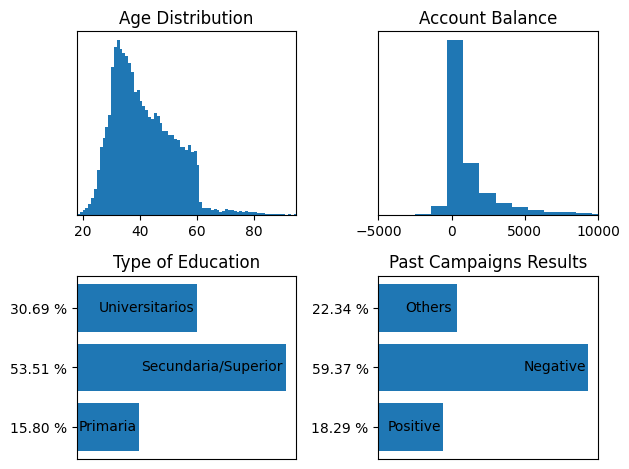

In [8]:
# Distribution of some relevant profiles

data_size = data_train['ID'].size 

age_distribution = np.array(data_train['edad']).reshape((1, data_size))[0]
account_balance = np.array(data_train['saldo']).reshape((1, data_size))[0]
education_type = np.array(data_train['educacion']).reshape((1, data_size))[0]
past_campaigns = np.array(data_train['resultado_campanas_anteriores']).reshape((1, data_size))[0]

fig8, ax8 = plt.subplots(num=8, nrows=2, ncols=2, tight_layout=True, dpi=100)
bins = age_distribution.max() - age_distribution.min()
ax8[0, 0].set_title('Age Distribution')
ax8[0, 0].hist(age_distribution, bins=bins, align='mid')
ax8[0, 0].set_xlim([age_distribution.min(), age_distribution.max()])
ax8[0, 0].yaxis.set_visible(False)

ax8[0, 1].set_title('Account Balance')
ax8[0, 1].hist(account_balance, bins=100, align='mid')
ax8[0, 1].set_xlim([-5000, 10000]) # Only displaying <10k for visualization purposes
ax8[0, 1].yaxis.set_visible(False)

ax8[1, 0].set_title('Type of Education')
bin_names = ["Primaria", 'Secundaria/Superior', 'Universitarios']
counts = np.array([(education_type == 'priamaria').sum(), (education_type == 'secundaria/superiores').sum(), (education_type == 'universitarios').sum()])
ax8[1, 0].barh(range(len(bin_names)), counts, align='center')
ax8[1, 0].set_yticks(range(len(bin_names)), [f'{100 * counts[i]/counts.sum():.2f} %' for i in range(len(bin_names))])
text_xpos = [counts[2] - 5500, counts[1] - 8000, counts[0] - 3400]
for i in range(len(bin_names)):
    ax8[1, 0].text(text_xpos[- i - 1], i - 0.05, bin_names[i], ha = 'center')
ax8[1, 0].xaxis.set_visible(False)

ax8[1, 1].set_title('Past Campaigns Results')
bin_names = ["Positive", 'Negative', 'Others']
counts = np.array([(past_campaigns == 'exito').sum(), (past_campaigns == 'sin_exito').sum(), (past_campaigns == 'otro').sum()])
ax8[1, 1].barh(range(len(bin_names)), counts, align='center')
ax8[1, 1].set_yticks(range(len(bin_names)), [f'{100 * counts[i]/counts.sum():.2f} %' for i in range(len(bin_names))])
text_xpos = [counts[2] - 650, counts[1] - 750, counts[0] - 650]
for i in range(len(bin_names)):
    ax8[1, 1].text(text_xpos[- i - 1], i - 0.05, bin_names[i], ha = 'center')
ax8[1, 1].xaxis.set_visible(False)

plt.show()

### Preparation of the Data

For the models to work we need the data in numerical or boolean type.

In [9]:
# Convert data into Boolean

# Train set
unique_jobs_train = data_train['trabajo'].unique()
unique_jobs_train.sort()
jobs_counter_train = np.zeros(data_train['trabajo'].size)
for i, job in enumerate(unique_jobs_train):
    jobs_counter_train += i*(data_train['trabajo'] == job)
data_train['trabajo'] = jobs_counter_train
data_train["estado_civil"] = 2*(data_train["estado_civil"] == 'divorciado') + (data_train["estado_civil"] == 'casado')
data_train["educacion"] = 2*(data_train["educacion"] == 'universitarios') + (data_train["educacion"] == 'secundaria/superiores')
data_train["deuda"] = data_train["deuda"] == 'si'
data_train["vivienda"] = data_train["vivienda"] == 'si'
data_train["prestamo"] = data_train["prestamo"] == 'si'
data_train["target"] = data_train["target"] == 'si'
data_train["tipo_contacto"] = data_train["tipo_contacto"] == 'movil'
data_train["resultado_campanas_anteriores"] = data_train["resultado_campanas_anteriores"] == 'exito'

# Test set
unique_jobs_test = data_test['trabajo'].unique()
unique_jobs_test.sort()
jobs_counter_test = np.zeros(data_test['trabajo'].size)
for i, job in enumerate(unique_jobs_test):
    jobs_counter_test += i*(data_test['trabajo'] == job)
data_test['trabajo'] = jobs_counter_test
data_test["estado_civil"] = 2*(data_test["estado_civil"] == 'divorciado') + (data_test["estado_civil"] == 'casado')
data_test["educacion"] = 2*(data_test["educacion"] == 'universitarios') + (data_test["educacion"] == 'secundaria/superiores')
data_test["deuda"] = data_test["deuda"] == 'si'
data_test["vivienda"] = data_test["vivienda"] == 'si'
data_test["prestamo"] = data_test["prestamo"] == 'si'
data_test["target"] = data_test["target"] == 'si'
data_test["tipo_contacto"] = data_test["tipo_contacto"] == 'movil'
data_test["resultado_campanas_anteriores"] = data_test["resultado_campanas_anteriores"] == 'exito'

In [10]:
# Split the data into train/test with their respective targets
used_values = ["edad", "trabajo", "estado_civil", "educacion", "deuda", "saldo", "vivienda", "prestamo", 'tipo_contacto', "duracion", "campaign", "tiempo_transcurrido", "contactos_anteriores", "resultado_campanas_anteriores"]
Y_train = data_train["target"].values
X_train = data_train[used_values].values

Y_test = data_test["target"].values
X_test = data_test[used_values].values

In [11]:
job_number = []
for i, job in enumerate(unique_jobs_train):
    job_number.append(f'{job} = {i}')

summary = {'Job': tuple(job_number),
           'Marital Status': ('divorciado = 2', 'casado = 1', 'soltero = 0'), 
           'Education': ('univesitarios = 2', 'secundaria/superiores = 1', 'priamaria = 0'), 
           'Debt': ('si = True', 'no = False'), 
           'Living Place': ('si = True', 'no = False'), 
           'Loan': ('si = True', 'no = False'), 
           'Contact Type': ('mobil = True', 'fijo = False'), 
           'Past Campaigns\' Result': ('exito = True', 'sin_exito = False'), 
           'Target': ('si = True', 'no = False')}

summary_df = pd.DataFrame(summary.items(), columns=['Category', 'Number_Conversion'])
summary_df

,Category,Number_Conversion
0,Job,"(admin. = 0, blue-collar = 1, entrepreneur = 2..."
1,Marital Status,"(divorciado = 2, casado = 1, soltero = 0)"
2,Education,"(univesitarios = 2, secundaria/superiores = 1,..."
3,Debt,"(si = True, no = False)"
4,Living Place,"(si = True, no = False)"
5,Loan,"(si = True, no = False)"
6,Contact Type,"(mobil = True, fijo = False)"
7,Past Campaigns' Result,"(exito = True, sin_exito = False)"
8,Target,"(si = True, no = False)"


### Data Analysis

Before starting with the modeling process, we should determine and clarify the objective of the final model. Different objectives may yield different models so, as silly as it may seem, this process of objective clarification is the key for a good model. 

To see why this part is so important let's take a look at a simple example. Imagine we have a model to predict if a transaction is legal and we have 10k transactions a day, of which 9.9k are legal and only 0.1k are ilegal transactions. We build a model which predicts that every transaction is legal always and we analyze the results. Of 10k transactions 9.9k were correctly labeled as legal yielding 99% accuracy from the model. That's good right? Of course not, because of 100 ilegal transactions none where caugth.

In this example we can see why choosing the wrong objective can yield to bad models. Accuracy encourages correct labels but when the data is not evenly distributed it becomes a wrong objective.

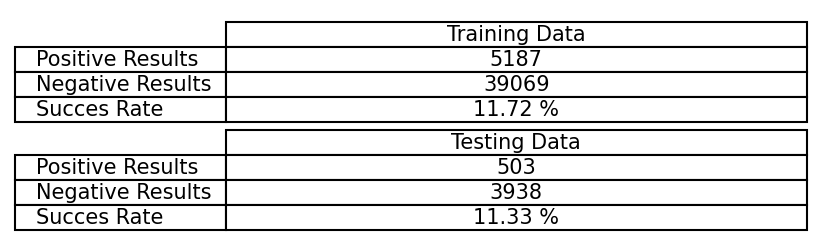

In [12]:
# Scanning of the target
positive_train = data_train['target'].sum()
total_train = data_train['target'].size
positive_test = data_test['target'].sum()
total_test = data_test['target'].size
row_labels = ['Positive Results', 'Negative Results', 'Succes Rate']
target_data_train = [[positive_train], [total_train - positive_train], [f'{100 * positive_train/total_train:.2f} %']]
target_data_test = [[positive_test], [total_test - positive_test], [f'{100 * positive_test/total_test:.2f} %']]

fig7, ax7 = plt.subplots(figsize=(5, 1), num=7, dpi=150)
ax7.axis('off')
ax7.axis('tight')
ax7.table(colLabels=['Training Data'], rowLabels=row_labels, cellText=target_data_train, loc='center', cellLoc='center')
ax7.table(colLabels=['Testing Data'], rowLabels=row_labels, cellText=target_data_test, loc='bottom', cellLoc='center')
plt.show()

As seen in the quick examination above only 11.7% is considered a positive result so we conclude that the data is unevenly distributed.

Now it's time to choose a good objective. Let's sum up some of the most common objectives used and choose between one of them:
- Accuracy (defined as $\frac {Correct Predictions} {Total Predictions}$): Most of the **data** will be correctly classified.

- Precision (defined as $\frac {Correct Positive Predictions} {Total Positive Predictions}$): Reduces the **false positive** cases.

- Recall/Sensitivity (defined as $\frac {Correct Positive Predictions} {Real Positives}$): Most of the **real positive** cases will be correctly classified. **False positive** cases are in consequence increased.

- F1 Score (defined as $\frac {2·Precision·Recall} {Precision + Recall}$): It's the harmonic average of precision and recall.

To choose the correct objective lets review what do we want to achieve:
- *We have too many clients and we wanted to optimize our workers time. We want to call **only** the people susceptive to buy the offer*

As we want that ideally every client called buys the offer, **PRECISION** is the best choice as it will reduce the number of calls that yield negative results.

### Logistic Regression Model

Let's first try lineal model called *'Logistic regression'* where the model will use an *'n dimensional'* line to split the data into 2 zones, the *'Yes'* zone and the *'No'* zone.

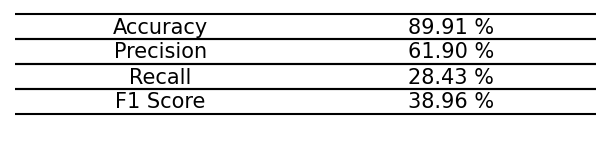

In [13]:
# Logistic Regression Model
linear_model = LogisticRegression(max_iter=int(1e4))
linear_model.fit(X_train, Y_train)
linear_predictions = linear_model.predict(X_test)
linear_scores = accuracy_score(Y_test, linear_predictions), precision_score(Y_test, linear_predictions), recall_score(Y_test, linear_predictions), f1_score(Y_test, linear_predictions)
scores_titles = ["Accuracy", "Precision", "Recall", "F1 Score"]

fig0, ax0 = plt.subplots(figsize=(5, 0.1), num=0, dpi=150)
ax0.axis('off')
ax0.axis('tight')
ax0.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(linear_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

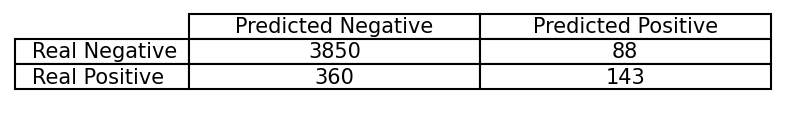

In [14]:
# Calculate the linear model confusion martix
linear_confusion_matrix = confusion_matrix(Y_test, linear_predictions)
fig5, ax5 = plt.subplots(figsize=(5, 0.1), num=5, dpi=150)
ax5.axis('off')
ax5.axis('tight')
ax5.table(colLabels=['Predicted Negative', 'Predicted Positive'], rowLabels=['Real Negative', 'Real Positive'], cellText=linear_confusion_matrix, loc='top', cellLoc='center')
plt.show()

### Decision Tree Model

Let's try now a type of model called *'decision tree'* where, setting the correct boundaries (prunning), one can make prediction with 'yes' or 'no' questions.

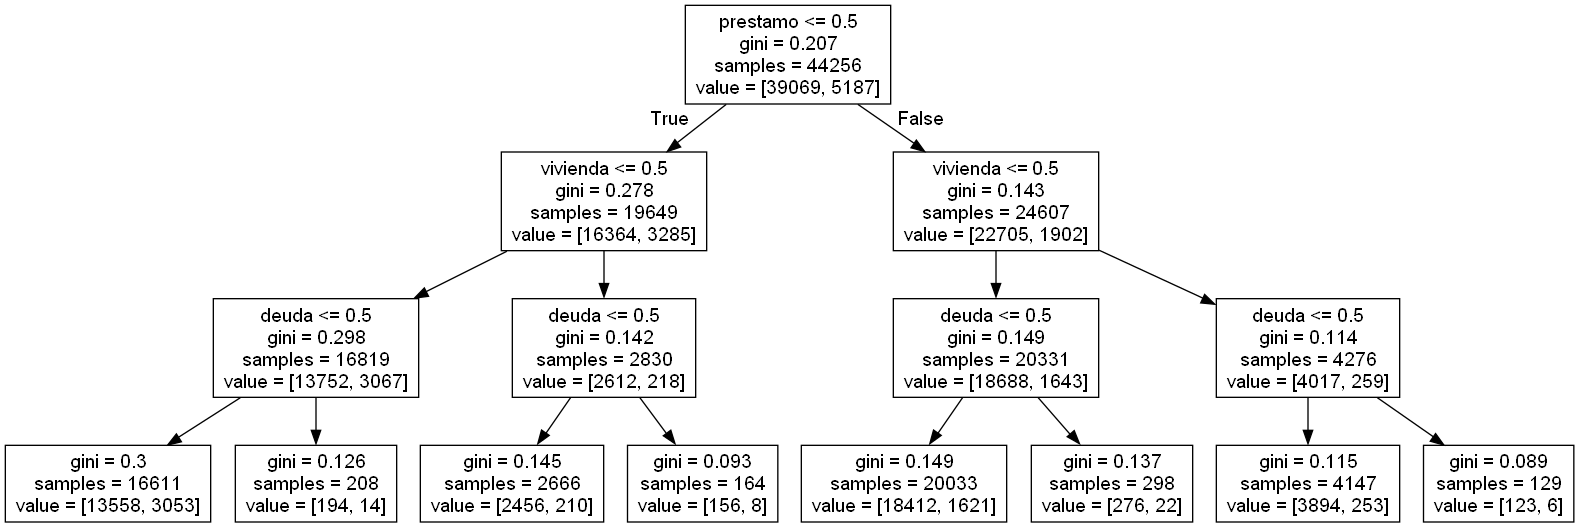

In [15]:
# Small Tree for demo purposes
Y_train_small = data_train["target"].values
X_train_small = data_train[["deuda", "vivienda", "prestamo"]].values

tree_model_small = DecisionTreeClassifier()
tree_model_small.fit(X_train_small, Y_train_small)

dot_file = export_graphviz(tree_model_small, feature_names=['deuda', 'prestamo', 'vivienda'])
graph = graphviz.Source(dot_file)
graph.render(filename='tree_1', format='png', cleanup=True)
tree_png = Image.open("tree_1.png")
display(tree_png)

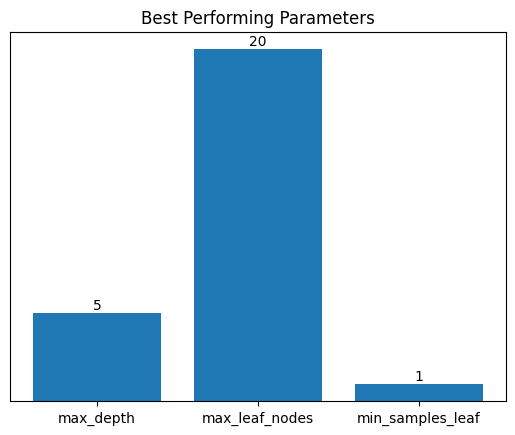

In [16]:
# Looking for the best scoring parameters
possible_params = {'max_depth': [5, 15, 20, 30], 'min_samples_leaf': [1, 3, 5], 'max_leaf_nodes': [10, 20, 35, 50]}
tree_test_model = DecisionTreeClassifier()
grid_search_tree = GridSearchCV(tree_test_model, possible_params, scoring='precision', cv=5)
grid_search_tree.fit(X_train, Y_train)
best_params_tree = grid_search_tree.best_params_

fig1, ax1 = plt.subplots(num=1, dpi=100)
ax1.set_title('Best Performing Parameters')
ax1.bar(range(len(best_params_tree)), list(best_params_tree.values()), align='center')
ax1.set_xticks(range(len(best_params_tree)), list(best_params_tree.keys()))
ax1.yaxis.set_visible(False)
for i in range(len(best_params_tree)):
    ax1.text(i, list(best_params_tree.values())[i] + 0.2, list(best_params_tree.values())[i], ha = 'center')
plt.show()

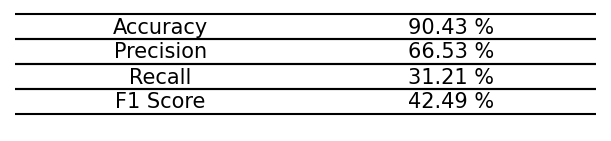

In [17]:
# Training a tree model with the best performing parameters found before
max_depth, max_leaf_nodes, min_samples_leaf = list(best_params_tree.values())
tree_model = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)
tree_model.fit(X_train, Y_train)
tree_predictions = tree_model.predict(X_test)

tree_scores = accuracy_score(Y_test, tree_predictions), precision_score(Y_test, tree_predictions), recall_score(Y_test, tree_predictions), f1_score(Y_test, tree_predictions)

fig2, ax2 = plt.subplots(figsize=(5, 0.1), num=2, dpi=150)
ax2.axis('off')
ax2.axis('tight')
ax2.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(tree_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

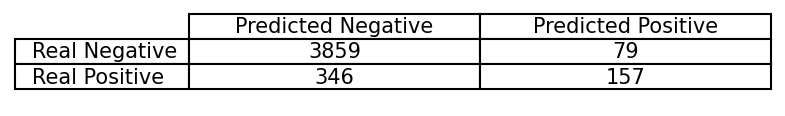

In [18]:
# Calculate the tree model confusion martix
tree_confusion_matrix = confusion_matrix(Y_test, tree_predictions)
fig6, ax6 = plt.subplots(figsize=(5, 0.1), num=6, dpi=150)
ax6.axis('off')
ax6.axis('tight')
ax6.table(colLabels=['Predicted Negative', 'Predicted Positive'], rowLabels=['Real Negative', 'Real Positive'], cellText=tree_confusion_matrix, loc='top', cellLoc='center')
plt.show()

### Random Forest Model

Once the tree model is trained, the predictions become determinate giving each parameter the same weight in each prediction. One way to mitigate this efect is to create a *'council'* of tree models, each trained with different characterstics of the dataset, that will *'vote'* in every prediction. The label with the most votes (majority in our case because there is only two labels) will be the resulting prediction. As each tree of this *'coucil'* weights each characteristic in a different way we reduce the chance of biasing the model. 
Let's start by building a basic model to discuss some properties:

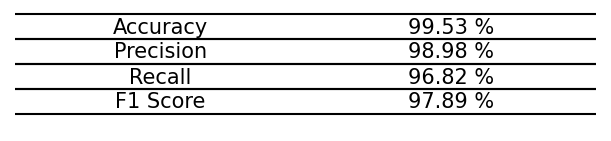

In [19]:
# Training a random forest model with the best parameters found before
seed = 50 # Set seed for reproducibility
random_forest_model = RandomForestClassifier(max_features=5, n_estimators=20, random_state=seed)
random_forest_model.fit(X_train, Y_train)

random_forest_predictions = random_forest_model.predict(X_test)

random_forest_scores = accuracy_score(Y_test, random_forest_predictions), precision_score(Y_test, random_forest_predictions), recall_score(Y_test, random_forest_predictions), f1_score(Y_test, random_forest_predictions)

fig10, ax10 = plt.subplots(figsize=(5, 0.1), num=10, dpi=150)
ax10.axis('off')
ax10.axis('tight')
ax10.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(random_forest_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

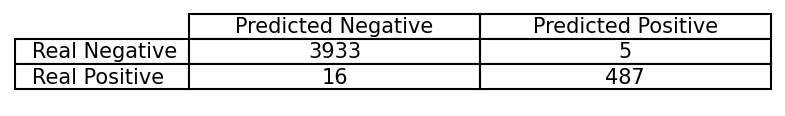

In [20]:
# Calculate the tree model confusion martix
rf_confusion_matrix = confusion_matrix(Y_test, random_forest_predictions)
fig11, ax11 = plt.subplots(figsize=(5, 0.1), num=11, dpi=150)
ax11.axis('off')
ax11.axis('tight')
ax11.table(colLabels=['Predicted Negative', 'Predicted Positive'], rowLabels=['Real Negative', 'Real Positive'], cellText=rf_confusion_matrix, loc='top', cellLoc='center')
plt.show()

As we can see performs very well with a 98.8% precision, but we can do a bit better. First lets see how each category impacts the final result. Then we can sort the categories by relevance and use only the ones that are the most impactful.

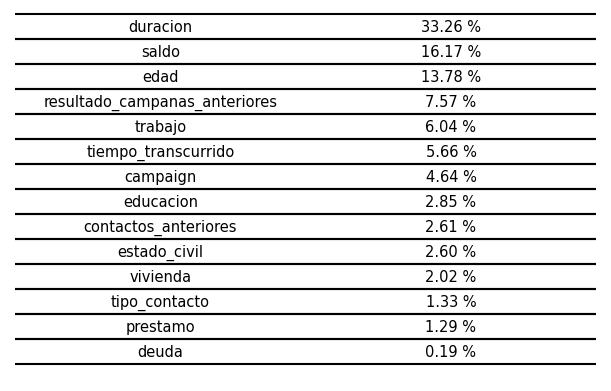

In [21]:
# Looking for the most impactful characteristics
def takeSecond(elem):
    return elem[1]

fig12, ax12 = plt.subplots(figsize=(5, 0.1), num=12, dpi=150)
feature_importances_sorted = sorted(zip(used_values, random_forest_model.feature_importances_), reverse=True, key=takeSecond)
feature_importances = [[i[0], f'{100 * i[1]:.2f} %'] for i in feature_importances_sorted]
ax12.axis('off')
ax12.axis('tight')
ax12.table(cellText=feature_importances, loc='top', cellLoc='center', edges='horizontal')
plt.show()

In [22]:
# Testing performance using different features
def prepare_data(categories):
    train = data_train[categories].values
    test = data_test[categories].values
    return (train, test)
feature_names_sorted = [i[0] for i in feature_importances_sorted]
precision_features = np.array([])
for i in range(len(feature_names_sorted) - 1):
    train, test = prepare_data(feature_names_sorted[:i+1])
    random_forest_model = RandomForestClassifier(max_features=5, n_estimators=20, random_state=seed)
    random_forest_model.fit(train, Y_train)

    random_forest_predictions = random_forest_model.predict(test)

    random_forest_scores = accuracy_score(Y_test, random_forest_predictions), precision_score(Y_test, random_forest_predictions), recall_score(Y_test, random_forest_predictions), f1_score(Y_test, random_forest_predictions)
    precision_features = np.append(precision_features, random_forest_scores[2])

TypeError: 'numpy.ndarray' object is not callable

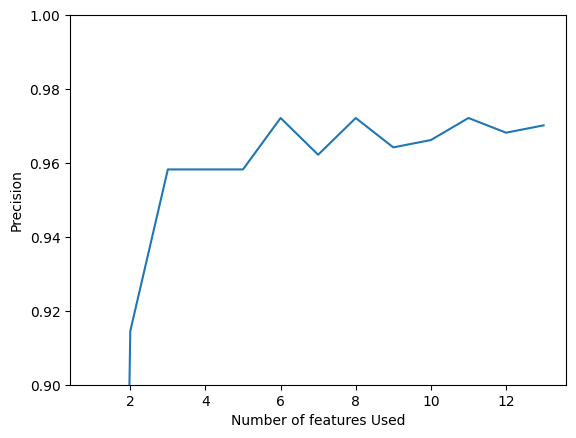

In [ ]:
fig13, ax13 = plt.subplots(num=13)
ax13.set_ylabel('Precision')
ax13.set_xlabel('Number of features Used')
ax13.plot(np.arange(len(precision_features)) + 1, precision_features)
ax13.set_ylim(0.9, 1)
plt.show()

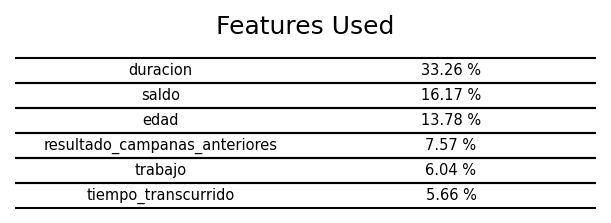

In [ ]:
used_features_rf = feature_names_sorted[:6]
X_train_rf , X_test_rf = prepare_data(used_features_rf)

fig14, ax14 = plt.subplots(figsize=(5, 0.1), num=14, dpi=150)
feature_importances = [[i[0], f'{100 * i[1]:.2f} %'] for i in feature_importances_sorted[:6]]
ax14.set_title('Features Used')
ax14.axis('off')
ax14.axis('tight')
ax14.table(cellText=feature_importances, loc='bottom', cellLoc='center', edges='horizontal')
plt.show()

As seen in the lasts figures, once we have used 6 features (relevance > 5%) the precision stabilizes around 97%. So from now on, to train the next random forest models we will only use these 6 most relevant features.

Now it is time to look for the best parameters for our model. This precedure is necessary not only to avoid low precision models (meaning 90% or less in our case) but to avoid the contrary, overfitting.

In [ ]:
# Scanning for the best parameters of the random forest model WITH KFold cross validation
random_forest_test_model = RandomForestClassifier(random_state=seed)
possible_params = {'max_features':[3, 5, 7], 'n_estimators': [10, 25, 50, 75, 100]}
grid_search_rf = GridSearchCV(random_forest_test_model, possible_params, scoring='precision', cv=10)
grid_search_rf.fit(X_train_rf, Y_train)
best_params_rf = grid_search_rf.best_params_

In [ ]:
# Calculating the elbow graph (precision vs n_estimators)
random_forest_elbow_model = RandomForestClassifier(random_state=seed)
elbow_params = {'n_estimators': range(1, 75)}
grid_search_rf_elbow = GridSearchCV(random_forest_elbow_model, elbow_params, scoring='precision', cv=10)
grid_search_rf_elbow.fit(X_train_rf, Y_train)
best_params_rf_elbow = grid_search_rf_elbow.best_params_

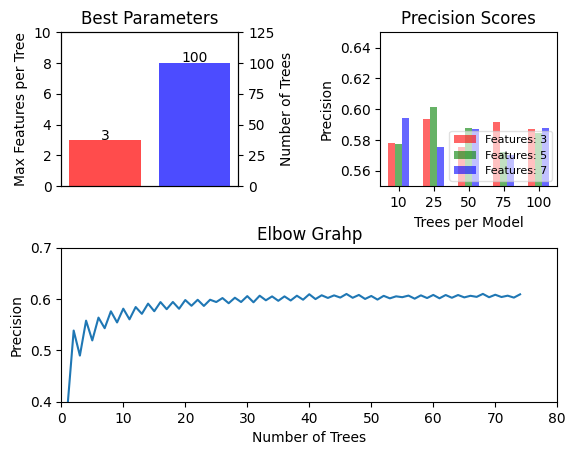

In [ ]:
# Plot of the afforementioned scan
ax9 = np.zeros(3, dtype=object)
fig9 = plt.figure(num=9, dpi=100)

gs = mpl.gridspec.GridSpec(2, 2, wspace=0.8, hspace=0.4)
ax9[0] = fig9.add_subplot(gs[0, 0])
ax9[1] = fig9.add_subplot(gs[0, 1])
ax9[2] = fig9.add_subplot(gs[1, :])

ax9[0].set_title('Best Parameters')
ax9[0].set_ylabel('Max Features per Tree')
ax9[0].bar(0, list(best_params_rf.values())[0], align='center', color='r', alpha = 0.7)
ax9[0].set_xticks(range(len(best_params_rf)), list(best_params_rf.keys()))
ax9[0].set_ylim(0, 10)
ax9[0].xaxis.set_visible(False)
ax9[0].text(0, list(best_params_rf.values())[0], list(best_params_rf.values())[0], ha = 'center')

ax90 = ax9[0].twinx()
ax90.set_ylabel('Number of Trees')
ax90.bar(1, list(best_params_rf.values())[1], align='center', color='b', alpha = 0.7)
ax90.set_ylim(0, 125)
ax90.text(1, list(best_params_rf.values())[1] + 1, list(best_params_rf.values())[1], ha = 'center') 

scores = grid_search_rf.cv_results_['mean_test_score'].reshape(5, 3).T
ax9[1].set_title('Precision Scores')
index = np.arange(5)
bar_width = 0.2
features_3 = ax9[1].bar(index, scores[0], bar_width, color='r', alpha = 0.6, label='Features: 3')
features_5 = ax9[1].bar(index + bar_width, scores[1], bar_width, color='g', alpha = 0.6, label='Features: 5')
features_7 = ax9[1].bar(index + 2*bar_width, scores[2], bar_width, color='b', alpha = 0.6, label='Features: 7')
ax9[1].set_xlabel('Trees per Model')
ax9[1].set_ylabel('Precision')
ax9[1].set_xticks(index + bar_width, ('10', '25', '50', '75', '100'))
ax9[1].set_ylim(0.55, 0.65)
ax9[1].legend(loc='lower right', framealpha=0.6, fontsize='8')

ax9[2].set_title('Elbow Grahp')
ax9[2].plot(elbow_params['n_estimators'], grid_search_rf_elbow.cv_results_['mean_test_score'])
ax9[2].set_xlabel("Number of Trees")
ax9[2].set_ylabel("Precision")
ax9[2].set_xlim(0, 80)
ax9[2].set_ylim(0.4, 0.7)

plt.show()

Looking at the last results, the best number of trees should lie around 20-30 trees as seen in the *'elbow'* graph. At this point the precision only enhances slightly probably due to some overfitting. Reducing the number of trees of a random forest model is good for training times and avoid overfitting. We will use then 3 features per tree, 30 trees in total and train it with only the relevant categories found before.

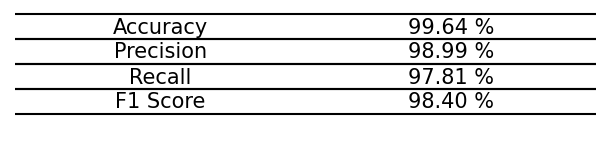

In [ ]:
# Training a random forest model with the best parameters found before and only the most relevant features
max_features, n_estimators = 3, 30
random_forest_model = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators, random_state=seed)
random_forest_model.fit(X_train_rf, Y_train)

random_forest_predictions = random_forest_model.predict(X_test_rf)

random_forest_scores = accuracy_score(Y_test, random_forest_predictions), precision_score(Y_test, random_forest_predictions), recall_score(Y_test, random_forest_predictions), f1_score(Y_test, random_forest_predictions)

fig10, ax10 = plt.subplots(figsize=(5, 0.1), num=10, dpi=150)
ax10.axis('off')
ax10.axis('tight')
ax10.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(random_forest_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

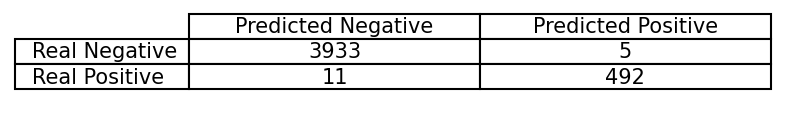

In [ ]:
# Calculate the tree model confusion martix
rf_confusion_matrix = confusion_matrix(Y_test, random_forest_predictions)
fig11, ax11 = plt.subplots(figsize=(5, 0.1), num=11, dpi=150)
ax11.axis('off')
ax11.axis('tight')
ax11.table(colLabels=['Predicted Negative', 'Predicted Positive'], rowLabels=['Real Negative', 'Real Positive'], cellText=rf_confusion_matrix, loc='top', cellLoc='center')
plt.show()

**Note:** As one can see inspecting the results, when looking for the best parameters for the random forest model the evaluation got ALL the possible configurations around 60% of precision but the model performed with a 99.2% on the test dataset. Why is that? At first it can seem that something is wrong but further analysis shows that these models from the parameter testing perform almost as well on the test dataset. Testing models got trained with 35k datapoints (approximately), a bit less than the resulting model (which got around 44k), hence the sligthly lower performance over the test dataset. 
To explain the difference of performance between the test split and the test dataset various factors can interfere:
- Hard/Easy datasets: It could have happened that the training set is what is called a *'hard'* dataset and the test dataset might be an *'easy'* dataset. One may think of a hard dataset as one with a lot of variance or low correlation between the categories and the target.
- Luck: It could have happened that the splits were not selected properly biasing the results. Increasing the cross validation splits leads to similiar results taking luck out of the equation.
- Data leakage: It could have happened that many data from the test dataset is repeated in the train dataset, fakely enhancing the model performance.

### Neural Network

Finally we will approach the less intuitive model, the **neural network**. Classification models are more or less easy to understand what they are doing with the input data to reach a conclusion, but with neural networks it is not the case. Neural networks recieve an input, apply complex maths to extract the features and reach a conclusion.

(Note that neural networks are *'N classifiers'*, meaning that the output is not limited to 2 labels, though in our case we will use only 2 of them)

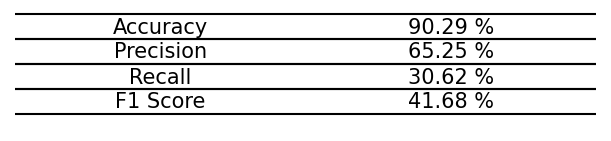

In [ ]:
# Neural network model
neural_network_model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100, 50))
neural_network_model.fit(X_train, Y_train)

neural_network_predictions = neural_network_model.predict(X_test)
neural_network_scores = accuracy_score(Y_test, neural_network_predictions), precision_score(Y_test, neural_network_predictions), recall_score(Y_test, neural_network_predictions), f1_score(Y_test, neural_network_predictions)
scores_titles = ["Accuracy", "Precision", "Recall", "F1 Score"]

fig13, ax13 = plt.subplots(figsize=(5, 0.1), num=13, dpi=150)
ax13.axis('off')
ax13.axis('tight')
ax13.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(neural_network_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

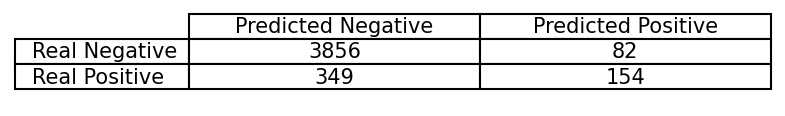

In [ ]:
# Calculating the confusion matrix
neural_network_confusion_matrix = confusion_matrix(Y_test, neural_network_predictions)
fig14, ax14 = plt.subplots(figsize=(5, 0.1), num=14, dpi=150)
ax14.axis('off')
ax14.axis('tight')
ax14.table(colLabels=['Predicted Negative', 'Predicted Positive'], rowLabels=['Real Negative', 'Real Positive'], cellText=neural_network_confusion_matrix, loc='top', cellLoc='center')
plt.show()

### Comparing the Models

Now that we tested some models we have to decide which will be the best in performance. Note that this is a subjective criteria (mostly) and the best model has to be chosen taking into account the dataset used and the objective the project has. We will start producing different models with diferent thresholds (separator value) and plotting a *'Receiver operating characteristic'* (ROC for short) of the **'sensitivity'** versus the **'specificity'**

As a reminder:
- Sensitivity (or recall) is calculated as $\frac {Correct Possitives} {Real Positives} = \frac {TP} {TP + FN}$

- Specificity is calculated as $\frac {Correct Negatives} {Real Negatives} = \frac {TN} {TN + FP}$

(As one can see these two metrics are complementary in the confusion matrix)

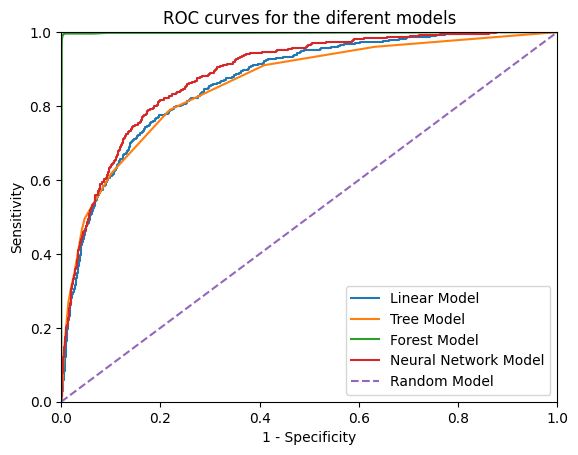

In [ ]:
# Comparison of the models
linear_pred_proba = linear_model.predict_proba(X_test)
fpr_linear, tpr_linear, thresholds_linear = roc_curve(Y_test, linear_pred_proba[:, 1])

tree_pred_proba = tree_model.predict_proba(X_test)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(Y_test, tree_pred_proba[:, 1])

rf_pred_proba = random_forest_model.predict_proba(X_test_rf)
fpr_random_forest, tpr_random_forest, thresholds_random_forest = roc_curve(Y_test, rf_pred_proba[:, 1])

neural_network_pred_proba = neural_network_model.predict_proba(X_test)
fpr_neural_network, tpr_neural_network, thresholds_neural_network = roc_curve(Y_test, neural_network_pred_proba[:, 1])

fig3, ax3 = plt.subplots(num=3)
ax3.set_title('ROC curves for the diferent models')
ax3.plot(fpr_linear, tpr_linear, label='Linear Model')
ax3.plot(fpr_tree, tpr_tree, label='Tree Model')
ax3.plot(fpr_random_forest, tpr_random_forest, label='Forest Model')
ax3.plot(fpr_neural_network, tpr_neural_network, label='Neural Network Model')
ax3.plot([0, 1], [0, 1], linestyle='--', label='Random Model') # If a model were to work chosing randomly the ROC curve would be a line
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
ax3.set_xlabel('1 - Specificity')
ax3.set_ylabel('Sensitivity')
plt.legend()
plt.show()

As we can see different models yield different ROC curves. As the purple line is the *'random model'*, if one model is far from this line, it means it is perfoming better. But which point of the curve should we chose to evaluate the model? As the point depends on the data and objective, an arbitrary metric to evaluate the model would be to measure the area under the ROC curve. If the area is larger means that the model is further from the random model line in average than the other models.

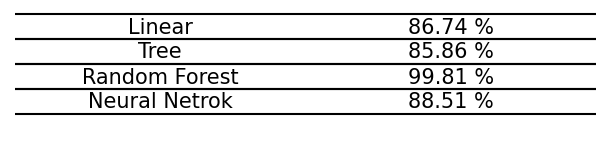

In [ ]:
# Calculating area under the curve (AUC) of the models
models_name = ['Linear', 'Tree', 'Random Forest', 'Neural Netrok']
models_auc = roc_auc_score(Y_test, linear_pred_proba[:, 1]), roc_auc_score(Y_test, tree_pred_proba[:, 1]), roc_auc_score(Y_test, rf_pred_proba[:, 1]), roc_auc_score(Y_test, neural_network_pred_proba[:, 1])

fig4, ax4 = plt.subplots(figsize=(5, 0.1), num=4, dpi=150)
ax4.axis('off')
ax4.axis('tight')
ax4.table(cellText=[[models_name[i], f'{100 * v:.2f} %'] for i, v in enumerate(models_auc)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

### Conclusion

We have checked 4 types of models. Every model has its pros and cons but we will evaluate them by the training time and performance.
- Training Time: The times went from hundreds of milisecons for the decision tree, to a couple seconds for the logistic regression and the random forest, and to a solid dozen of seconds for the neural network.
- Performance: Recall that our metric for evaluation is **PRECISION**. The models precision went from 60% from the logistic regression, to 66-68% from the decision tree and the neural network, and to an astonishing 99% from the random forest (discussed before).

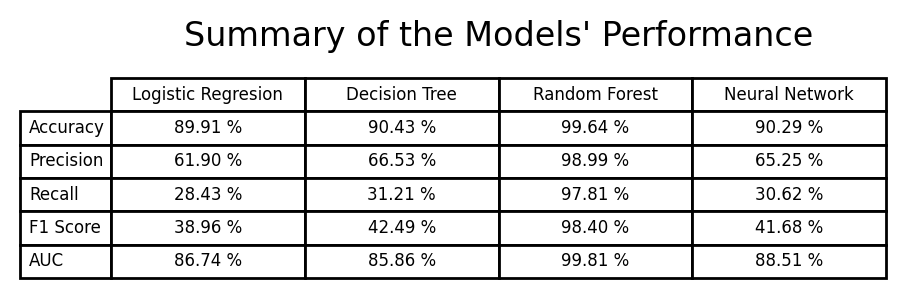

In [ ]:
# Summary of the results
models_summary = np.array([[f'{100 * v:.2f} %' for i, v in enumerate(linear_scores)], 
                            [f'{100 * v:.2f} %' for i, v in enumerate(tree_scores)], 
                            [f'{100 * v:.2f} %' for i, v in enumerate(random_forest_scores)], 
                            [f'{100 * v:.2f} %' for i, v in enumerate(neural_network_scores)]]).T
models_summary = np.vstack((models_summary, [f'{100 * v:.2f} %' for i, v in enumerate(models_auc)]))

neural_network_confusion_matrix = confusion_matrix(Y_test, neural_network_predictions)
fig16, ax16 = plt.subplots(figsize=(5, 0.1), num=16, dpi=200)
ax16.axis('off')
ax16.axis('tight')
ax16.set_title('Summary of the Models\' Performance')
ax16.table(colLabels=['Logistic Regresion', 'Decision Tree', 'Random Forest', 'Neural Network'], rowLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'], cellText=models_summary, loc='bottom', cellLoc='center')
plt.show()

### Choosing the Final Model

Looking at the resuls previously discussed, there is no doubt that the best performing model is the random forest. Though it has been the most tuned in this discussion, logistic regression and decision tree models are not capable to enhance its performance by much with tunning. Neural networks on the other hand are infinitely expandable meaning capacity to outperform the random forest model but it would require hours of hyperparameter optimization and probably an even bigger training time (as the neural network model took 10 times the random forest model training time with a simple layout).

In conclusion, the chosen model is the **random forest model** with *max features* = 3 and *number of trees* = 30. 

### Final Model

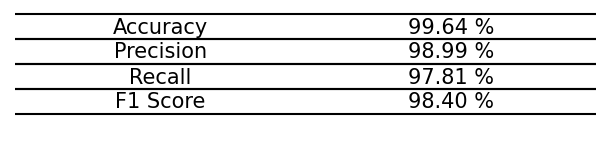

In [ ]:
# Training a random forest model with the best parameters found before and only the most relevant features
max_features, n_estimators = 3, 30
rf_final_model = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators, random_state=seed)
rf_final_model.fit(X_train_rf, Y_train)

random_forest_predictions = rf_final_model.predict(X_test_rf)

random_forest_scores = accuracy_score(Y_test, random_forest_predictions), precision_score(Y_test, random_forest_predictions), recall_score(Y_test, random_forest_predictions), f1_score(Y_test, random_forest_predictions)

fig17, ax17 = plt.subplots(figsize=(5, 0.1), num=17, dpi=150)
ax17.axis('off')
ax17.axis('tight')
ax17.table(cellText=[[scores_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(random_forest_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

In [ ]:
# Feel free to test any information with the final model below. Consult the table at the begining for info codification

user_features = np.array([0, # Last Call Duration
                        0, # Account Balance
                        21, # Age
                        False, # Past Campaigns' Results
                        0, # Job (consult the table at the begining for reference)
                        -1]) # Days from Last Call

rf_prediction = random_forest_model.predict([user_features])
print(rf_prediction[0])

False


### Implementation / Market Product

To be able to sell this product to a company some things has to be done previously:
- Implement an encoding function: By now the data is encoded 'manually' with a little script at the beggining. Better automatization of this process should be done.
- Save/Load model: The user might want to update the model using new data, thus being able to back up and load a new model is essential.
- Simplified version for the client: The code should be reduced to the essential parts only as the investigation process on the coding ide is not relevant for the client.
- Report of the project: Despite the coding issues we might have encountered, the conceptual problems and walls encountered during the problem solving process might still be relevant information for the client. It may help them undertand how and why the program is working the way we chose.
- GUI: The client or the people who will use the program will not be programmers (mostly). An UI that simplifies the use of the program to the push of some buttons is essential to ensure everybody can understand how the program works.